# Load and Process Data

In [ ]:
'''
The purpose of these models is to evaluate the hypothesis:
    Liabilities vs assets against interest rates rises in response to inflation
Datasets:
    FRB_H8_weekly_money_amounts.csv from the Federal Reserve
        Contains asset and liability data for all commercial banks
    FEDFUNDS.csv from the Federal Reserve
        Contains interest rate data
Models:
    K-Nearest-Neighbors with k=19 (found to be the optimal k)
    Gradiant Boosting
'''

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load data
frb_data_path = 'FRB_H8_weekly_money_amounts.csv'
fedfunds_data_path = 'FEDFUNDS.csv'

frb_raw_data = pd.read_csv(frb_data_path, header=None)
fedfunds_data = pd.read_csv(fedfunds_data_path)

# Process FRB data
frb_data = frb_raw_data.iloc[6:].reset_index(drop=True) #drop the first few rows of dataset info
frb_data.columns = frb_raw_data.iloc[5]
frb_data = frb_data[['Time Period', 'B1151NCBA', 'B1152NCBA']] #time, assets, & liability columns
frb_data.rename(columns={'Time Period': 'Date', 'B1151NCBA': 'Total_Assets', 'B1152NCBA': 'Total_Liabilities'}, inplace=True)
frb_data['Date'] = pd.to_datetime(frb_data['Date'])
frb_data['Total_Assets'] = pd.to_numeric(frb_data['Total_Assets'], errors='coerce')
frb_data['Total_Liabilities'] = pd.to_numeric(frb_data['Total_Liabilities'], errors='coerce')
frb_data.dropna(inplace=True)
#calculate the ratio for analysis
frb_data['Liabilities_Assets_Ratio'] = frb_data['Total_Liabilities'] / frb_data['Total_Assets']

# Process FEDFUNDS data
fedfunds_data['DATE'] = pd.to_datetime(fedfunds_data['DATE'])
#put all the data together
merged_data = pd.merge_asof(frb_data.sort_values('Date'), fedfunds_data.sort_values('DATE'), left_on='Date', right_on='DATE')

# Prepare features and target
features = merged_data[['FEDFUNDS', 'Liabilities_Assets_Ratio']]
target = merged_data['Total_Assets']

# Initialize scaler
scaler = MinMaxScaler()

# Scale features
scaled_features = scaler.fit_transform(features)

# Scale target
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

# Train-test split with scaled data
X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, random_state=42)

merged_data.head(10)

,Date,Total_Assets,Total_Liabilities,Liabilities_Assets_Ratio,DATE,FEDFUNDS
0,1973-01-03,706865.6,642063.7,0.908325,1973-01-01,5.94
1,1973-01-10,700978.7,625060.6,0.891697,1973-01-01,5.94
2,1973-01-17,699562.4,626054.8,0.894923,1973-01-01,5.94
3,1973-01-24,700885.2,619532.8,0.883929,1973-01-01,5.94
4,1973-01-31,705900.2,626777.0,0.887912,1973-01-01,5.94
5,1973-02-07,703473.6,619907.2,0.881209,1973-02-01,6.58
6,1973-02-14,709274.3,628014.9,0.885433,1973-02-01,6.58
7,1973-02-21,711760.1,633858.8,0.890551,1973-02-01,6.58
8,1973-02-28,718544.9,636858.3,0.886317,1973-02-01,6.58
9,1973-03-07,717513.7,633097.9,0.882350,1973-03-01,7.09


# Train & Evaluate KNN Model

Scaled KNN Mean Squared Error: 0.00245
Scaled KNN Mean Absolute Error: 0.01443


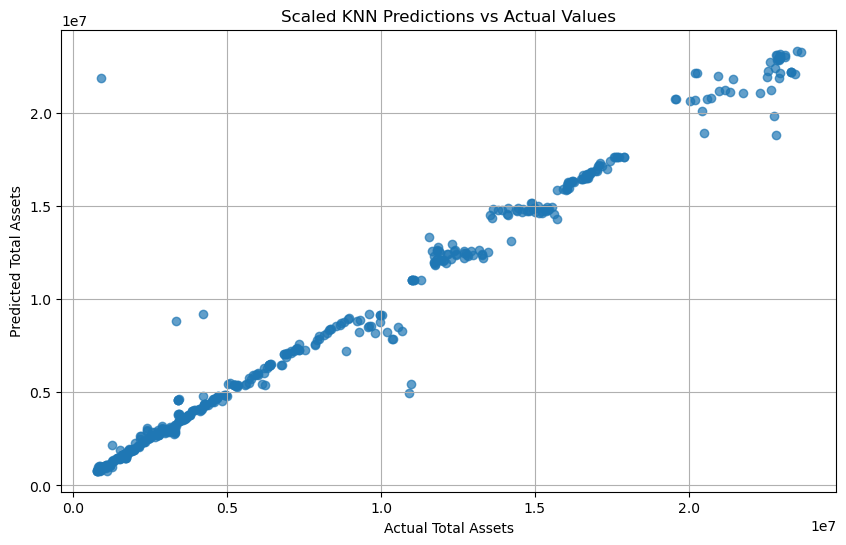

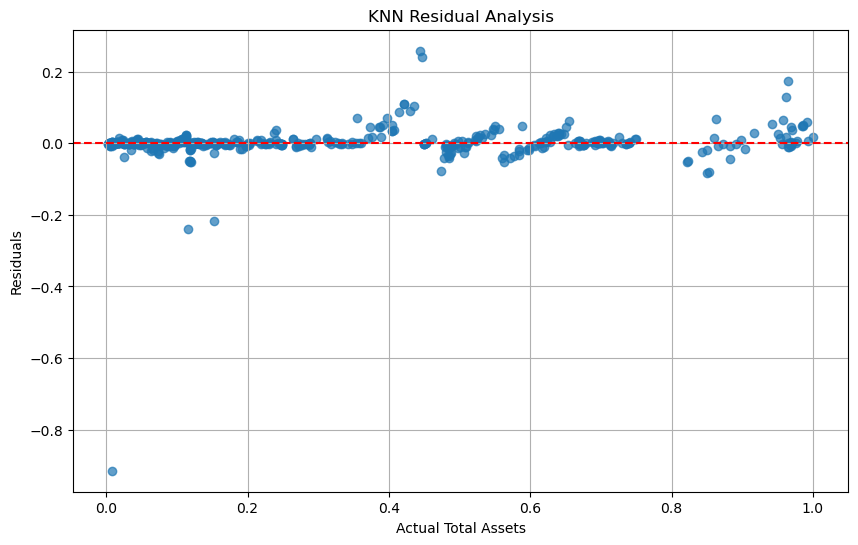

In [ ]:
# Train KNN with scaled data
knn = KNeighborsRegressor(n_neighbors=19) # optimal k
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Evaluate KNN with scaled data
mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)

print(f"Scaled KNN Mean Squared Error: {mse_knn:.5f}")
print(f"Scaled KNN Mean Absolute Error: {mae_knn:.5f}")

# Inverse transform the predictions and test data
y_test_original = scaler.inverse_transform(y_test)
y_pred_knn_original = scaler.inverse_transform(y_pred_knn)

# Plot KNN predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_knn_original, alpha=0.7)
plt.xlabel('Actual Total Assets')
plt.ylabel('Predicted Total Assets')
plt.title('Scaled KNN Predictions vs Actual Values')
plt.grid(True)
plt.show()

# Residual analysis for KNN
residuals_knn = y_test - y_pred_knn
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals_knn, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Total Assets")
plt.ylabel("Residuals")
plt.title("KNN Residual Analysis")
plt.grid(True)
plt.show()

# Train & Evaluate Gradient Boosting Model

Scaled Gradient Boosting Mean Squared Error: 0.00226
Scaled Gradient Boosting Mean Absolute Error: 0.02572


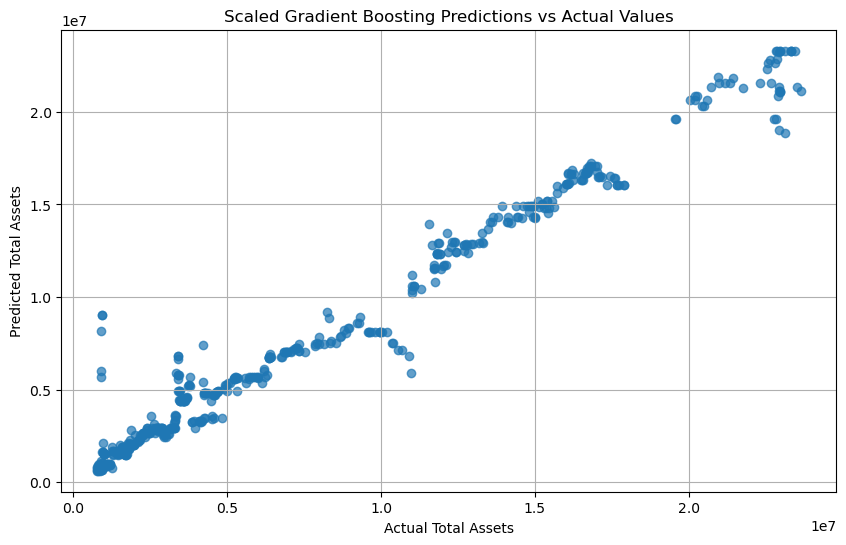

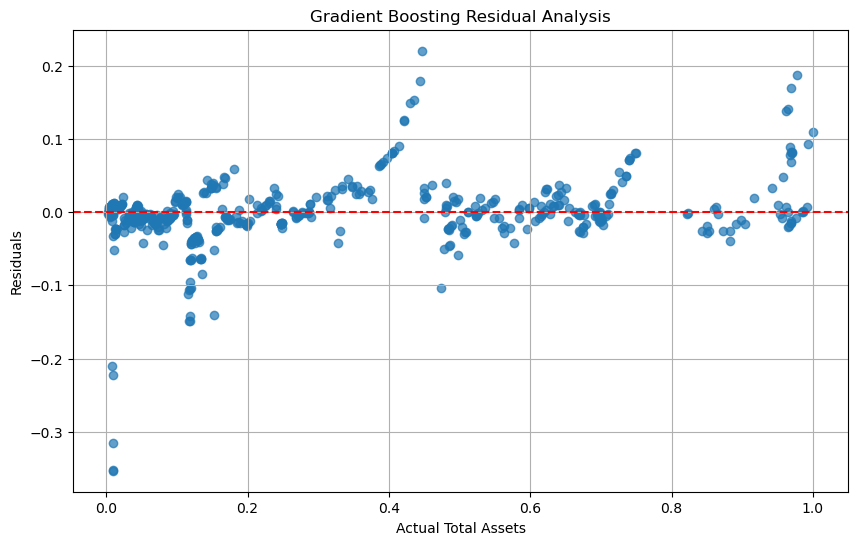

In [ ]:
# Train Gradient Boosting with scaled data
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train.ravel())  # Flatten y_train
y_pred_gb = gb_model.predict(X_test)

# Evaluate Gradient Boosting with scaled data
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)

print(f"Scaled Gradient Boosting Mean Squared Error: {mse_gb:.5f}")
print(f"Scaled Gradient Boosting Mean Absolute Error: {mae_gb:.5f}")

# Inverse transform the predictions and test data
y_test_original = scaler.inverse_transform(y_test)  # Ensure y_test is transformed back
y_pred_gb_original = scaler.inverse_transform(y_pred_gb.reshape(-1, 1))  # Reshape y_pred_gb

# Plot Gradient Boosting predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_gb_original, alpha=0.7)
plt.xlabel('Actual Total Assets')
plt.ylabel('Predicted Total Assets')
plt.title('Scaled Gradient Boosting Predictions vs Actual Values')
plt.grid(True)
plt.show()

# Residual analysis for Gradient Boosting
residuals_gb = y_test - y_pred_gb.reshape(-1, 1)  # Match shapes for residual computation
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals_gb, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Total Assets")
plt.ylabel("Residuals")
plt.title("Gradient Boosting Residual Analysis")
plt.grid(True)
plt.show()


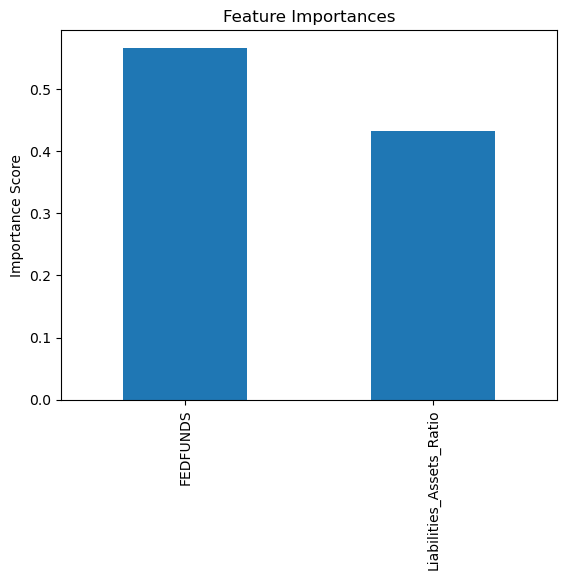

In [ ]:
# Feature importance for Gradient Boosting
feature_importances = pd.Series(gb_model.feature_importances_, index=features.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', title='Feature Importances')
plt.ylabel('Importance Score')
plt.show()

# Cross-validation for both models

In [ ]:
# Cross-validation for KNN with scaled data
cv_scores_knn = cross_val_score(knn, scaled_features, scaled_target.ravel(), cv=5, scoring='neg_mean_squared_error')
print(f"KNN Cross-Validation MSE: {-cv_scores_knn.mean():.5f}")

# Cross-validation for Gradient Boosting with scaled data
cv_scores_gb = cross_val_score(gb_model, scaled_features, scaled_target.ravel(), cv=5, scoring='neg_mean_squared_error')
print(f"Gradient Boosting Cross-Validation MSE: {-cv_scores_gb.mean():.5f}")

KNN Cross-Validation MSE: 0.14800
Gradient Boosting Cross-Validation MSE: 0.11738
